In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Get features from Simulations

In [3]:
parameters = c3.SimulationModelParameters.fetch().objs

# convert to JSON
parameters = parameters.toJson()

# convert to pandas df
df = pd.DataFrame(parameters)

# get the simulations ID in this order to match with target variable
simulations = pd.DataFrame(df['id'])

# get rid of some columns
X = df[df.columns[5:]]

# Get outputs from Cassandra

In [4]:
# define metric
bcacc_metric = c3.SimpleMetric(id = "AverageMassBCacc_SimulationSample",
                            name = "AverageMassBCacc_SimulationSample",
                            description = "Calculates average of massBCacc for a given SimulationSample",
                            srcType = "SimulationSample",
                            path = "output",  # the timeseries is in the output field of SimSam
                            expression = "avg(avg(normalized.data.mass_BC_acc))"
                              )

# define metric spec
my_spec = c3.EvalMetricsSpec(
            ids = simulations['id'],
            expressions = ["AverageMassBCacc_SimulationSample"],
            start = "2017-08-19T09:00:00.000",
            end = "2017-08-19T09:00:00.000",
            interval = "SECOND" 
            )

# evaluate metric with spec
evalMetricsResult = c3.SimulationSample.evalMetricsWithMetadata(
                                                                spec=my_spec,
                                                                overrideMetrics=[bcacc_metric]
                                                                )

# transform into c3 dataset
y = c3.EvalMetricsResult.toPandas(result=evalMetricsResult)

# Combine into a single dataframe

In [5]:
df = pd.DataFrame(X)
df['output'] = np.array(y['AverageMassBCacc_SimulationSample'])

In [6]:
df

,acure_bl_nuc,acure_ait_width,acure_cloud_ph,acure_carb_ff_ems,acure_carb_ff_ems_eur,acure_carb_ff_ems_nam,acure_carb_ff_ems_chi,acure_carb_ff_ems_asi,acure_carb_ff_ems_mar,acure_carb_ff_ems_r,...,bparam,two_d_fsd_factor,c_r_correl,acure_autoconv_exp_lwp,acure_autoconv_exp_nd,dbsdtbs_turb_0,ai,m_ci,a_ent_1_rp,output
0,0.500000,0.650000,0.396000,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.400000,0.900000,0.275862,0.605000,0.150000,0.514000,0.333333,0.460000,1.879328e-10
1,0.470000,0.500000,0.500000,1.0,0.530000,0.470000,0.530000,0.470000,0.530000,0.470000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.131719e-10
2,0.969888,0.083081,0.478474,1.0,0.577525,0.231615,0.283145,0.050178,0.419984,0.914346,...,0.927093,0.833905,0.610920,0.993935,0.755788,0.774187,0.960911,0.988952,0.508725,1.057840e-10
3,0.132847,0.445265,0.390414,1.0,0.925921,0.630498,0.187251,0.817525,0.147787,0.462419,...,0.950732,0.902536,0.780157,0.267910,0.018570,0.106893,0.218308,0.163327,0.936031,1.272986e-10
4,0.058261,0.630422,0.132292,1.0,0.009463,0.338064,0.913479,0.575490,0.412795,0.271141,...,0.129769,0.712185,0.552866,0.328090,0.651008,0.613814,0.101666,0.254514,0.089525,2.736529e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.591530,0.996801,0.170201,1.0,0.677187,0.865209,0.194226,0.526719,0.355815,0.187145,...,0.515917,0.891746,0.418227,0.732156,0.900471,0.035621,0.175431,0.482366,0.400788,1.146827e-10
217,0.774235,0.165151,0.881014,1.0,0.038024,0.157743,0.035123,0.946019,0.699902,0.097885,...,0.786932,0.231686,0.840574,0.349984,0.433408,0.930975,0.119901,0.777433,0.116056,2.904376e-10
218,0.227072,0.231834,0.185796,1.0,0.997232,0.609053,0.753345,0.219389,0.438737,0.928641,...,0.204519,0.096402,0.147632,0.313749,0.741739,0.144573,0.488763,0.245905,0.686731,1.116314e-10
219,0.047377,0.633909,0.721278,1.0,0.751703,0.047339,0.692896,0.994552,0.155710,0.762626,...,0.303059,0.898960,0.114170,0.725976,0.766313,0.259877,0.872825,0.966951,0.826032,5.828844e-11


# Histograms of features

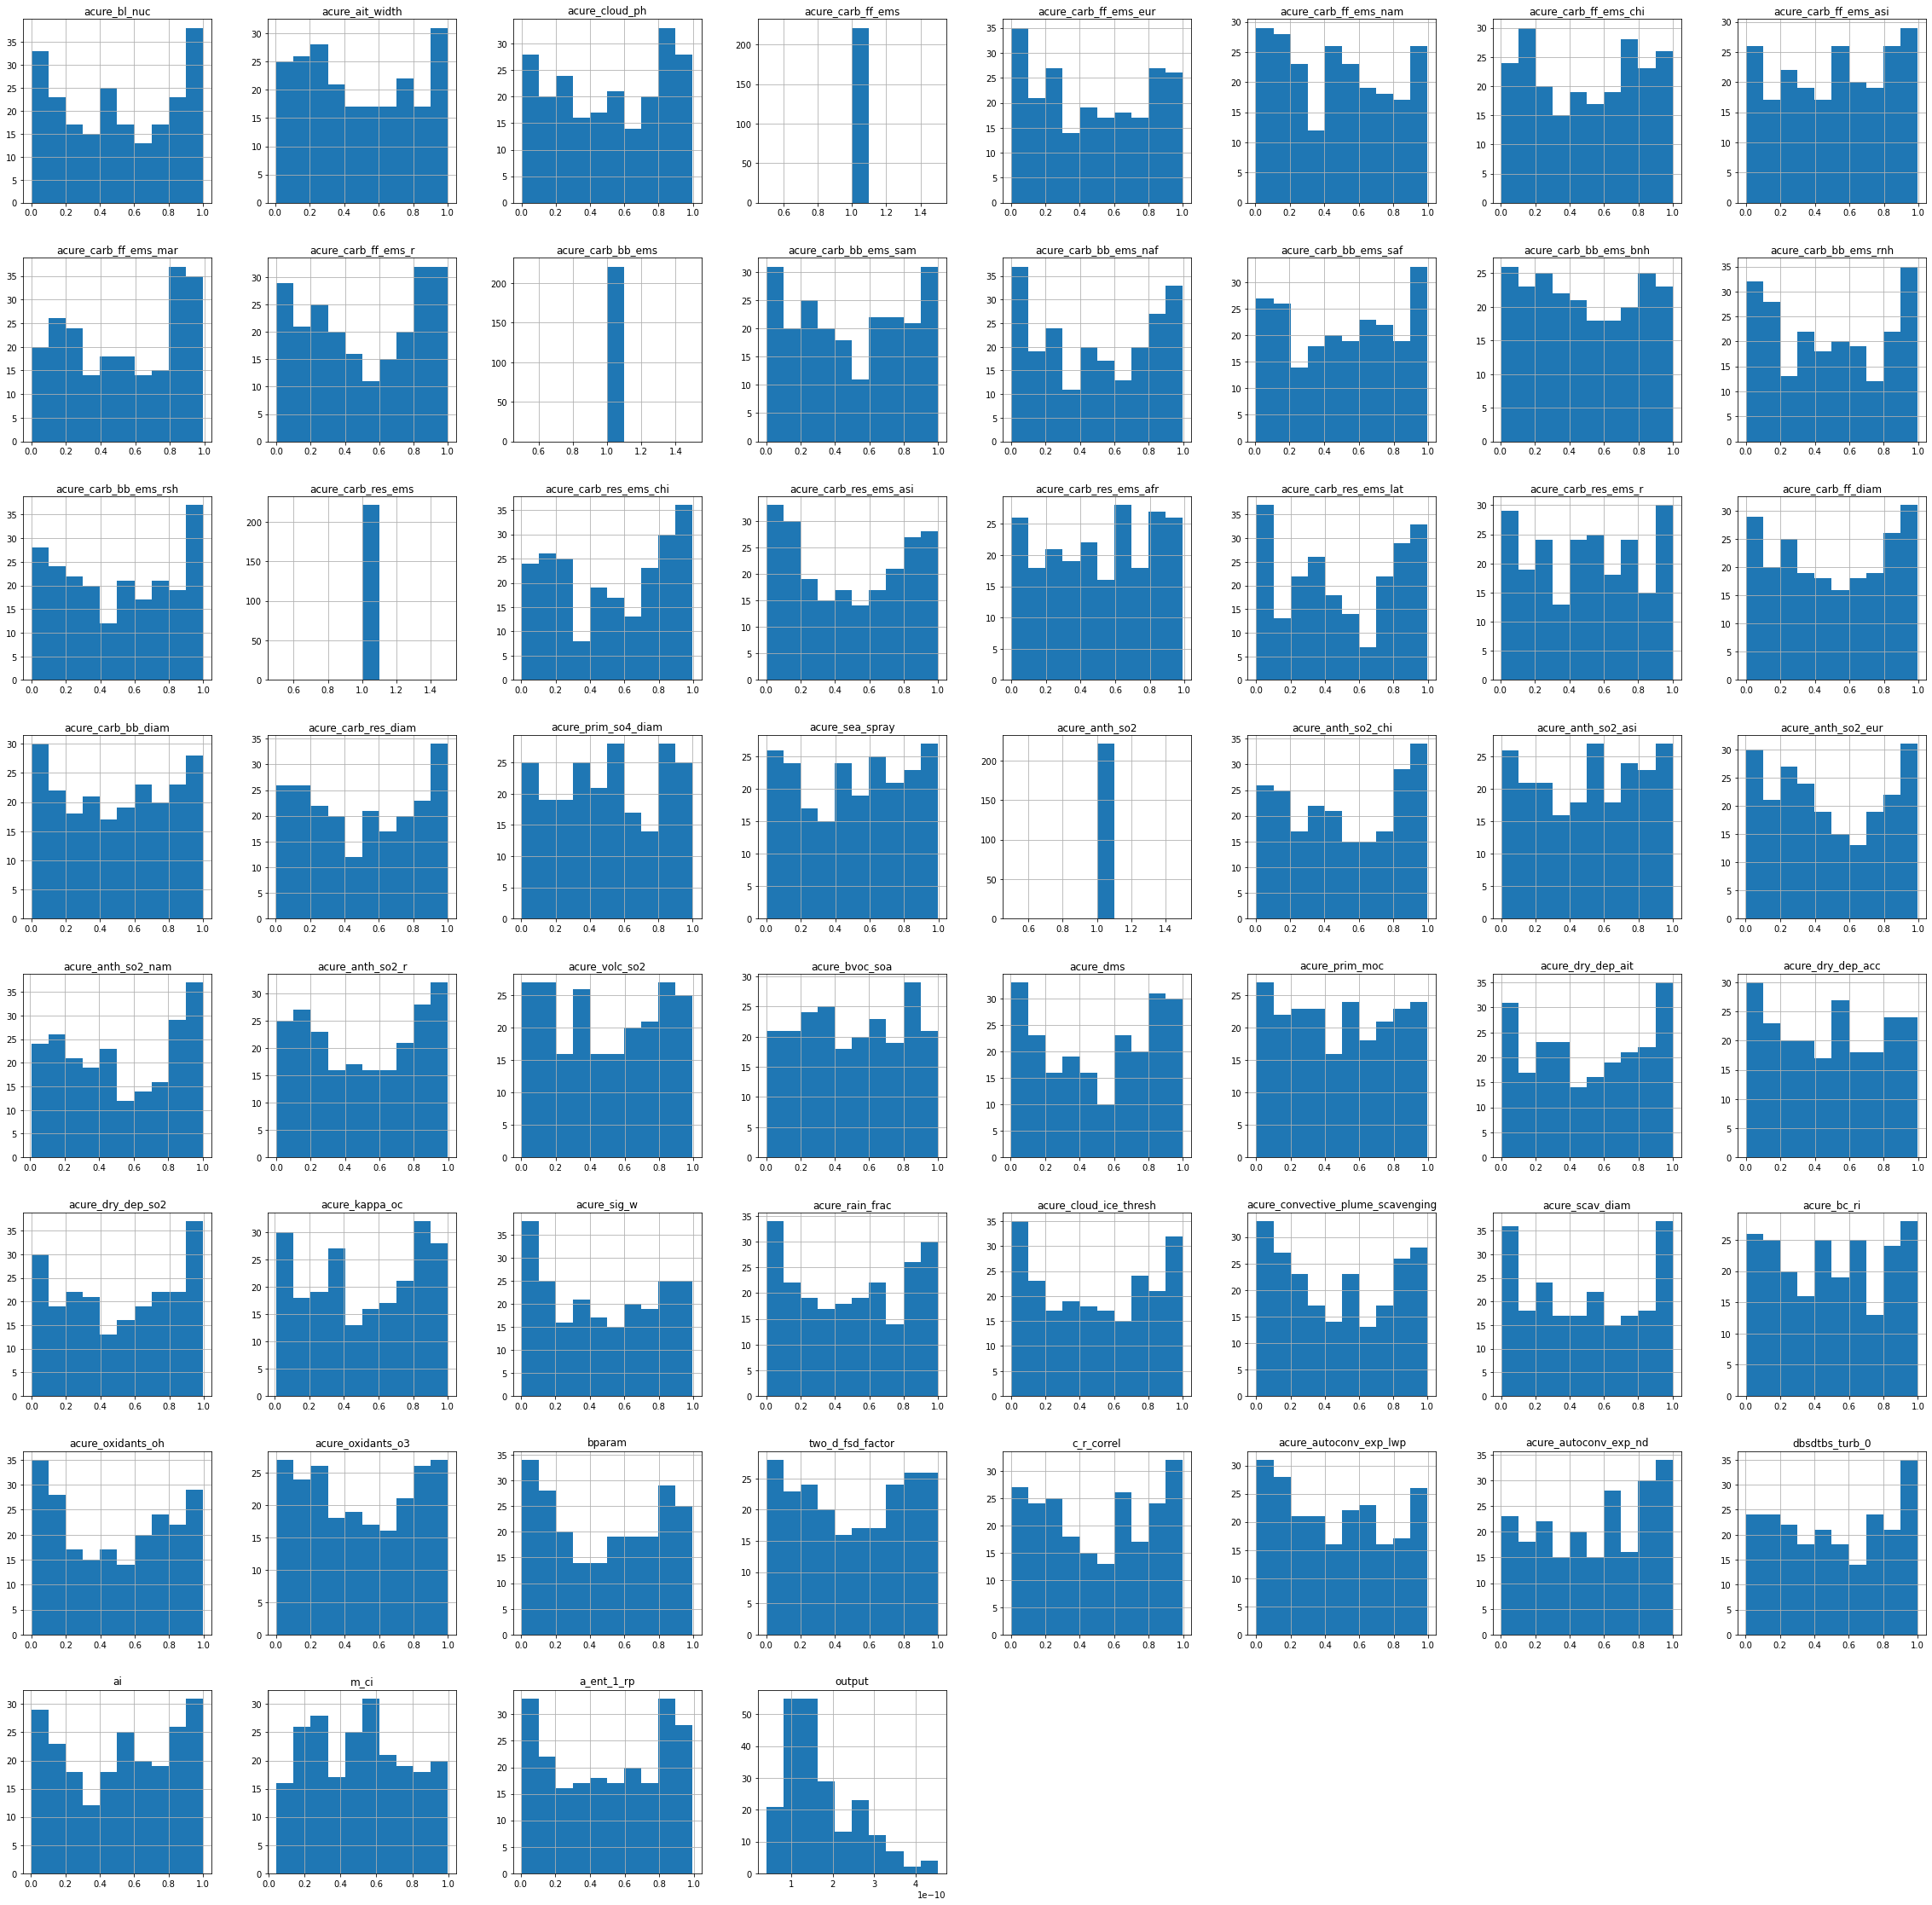

In [7]:
df.hist(figsize=(40,40));

#### Conclusions

Some variables have not been changed over the ensemble:
- *acure_carb_ff_ems*
- *acure_carb_bb_ems*
- *acure_carb_res_ems*
- *acure_anth_so2*

# Correlation Plots

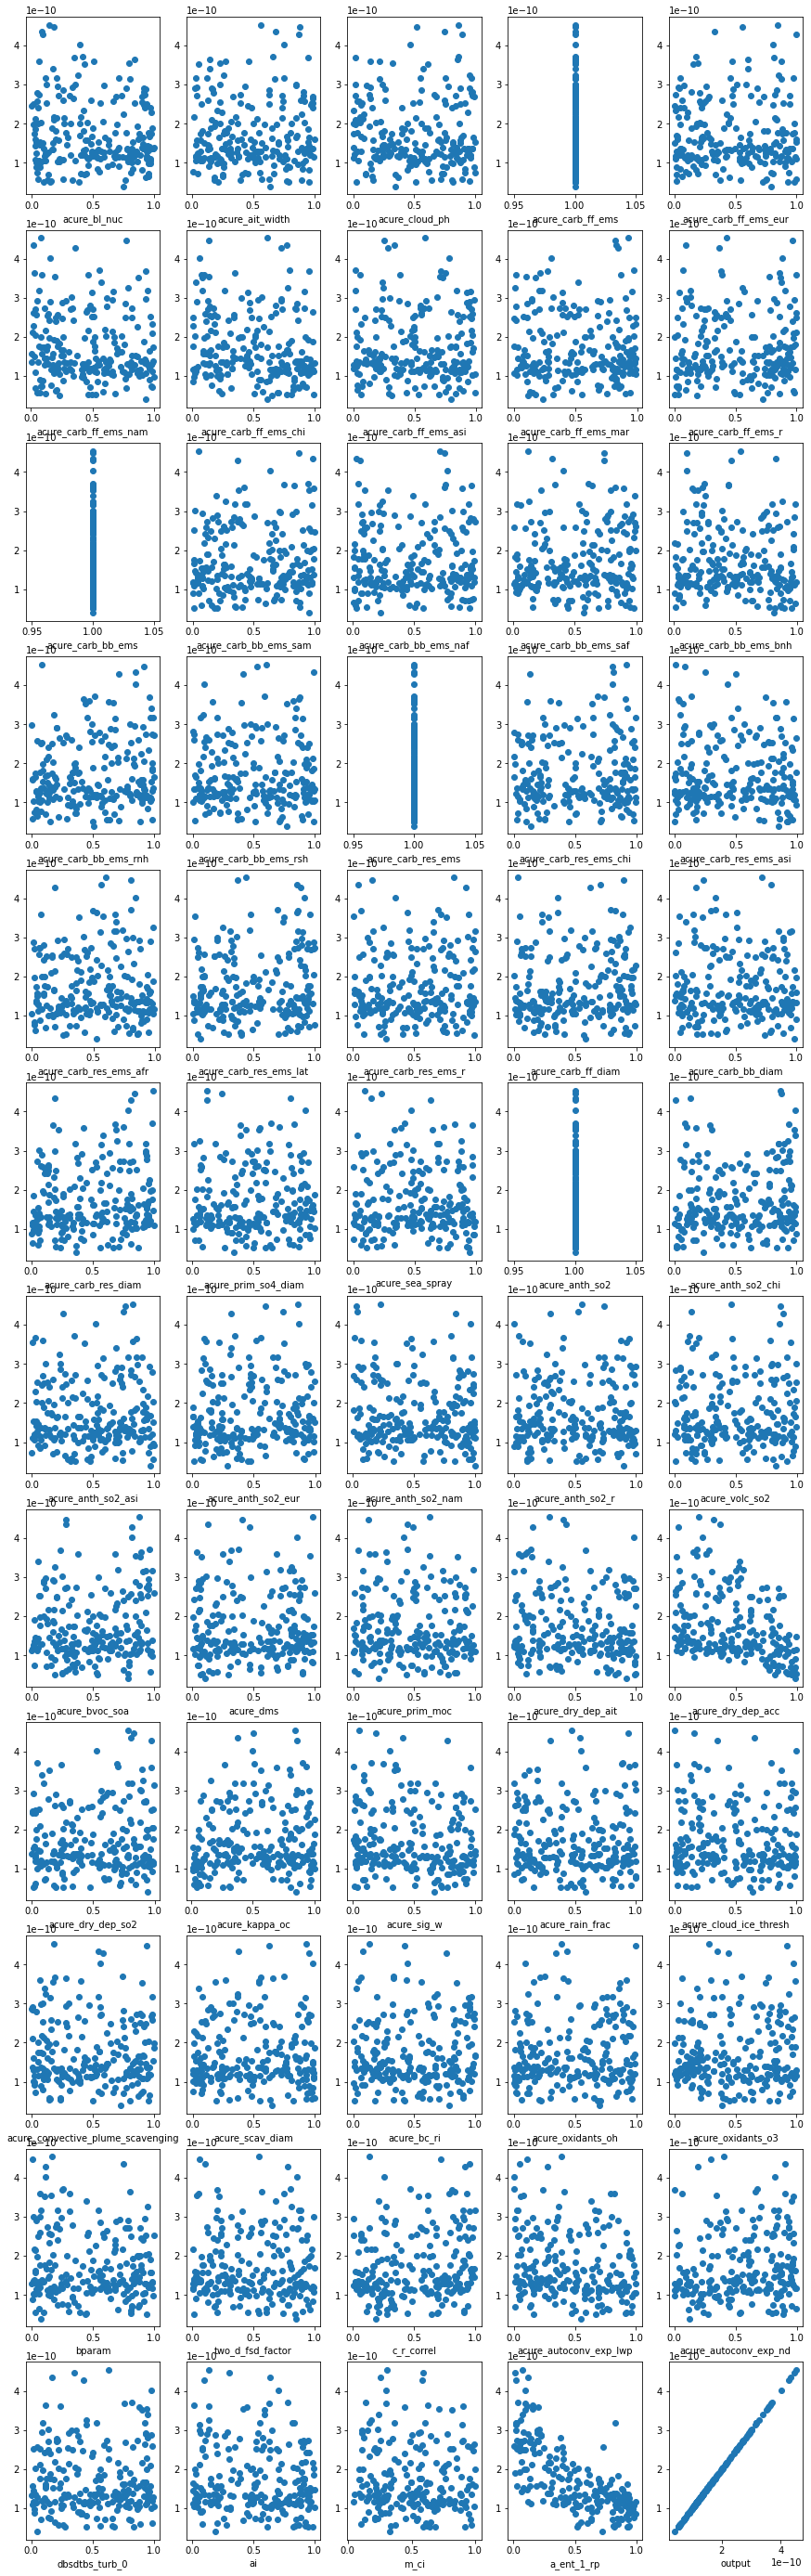

In [8]:
fig, ax = plt.subplots(12,5,figsize=(15,50))
for i in range(12):
    for j in range(5):
        ax[i,j].plot(df[df.columns[i*5 + j]], df.output, 'o')
        ax[i,j].set_xlabel(df.columns[i*5 + j])

#### Conclusions

Not a lot of visible correlations except for the the last variable: *a_ent_1_rp*

# Correlation matrix

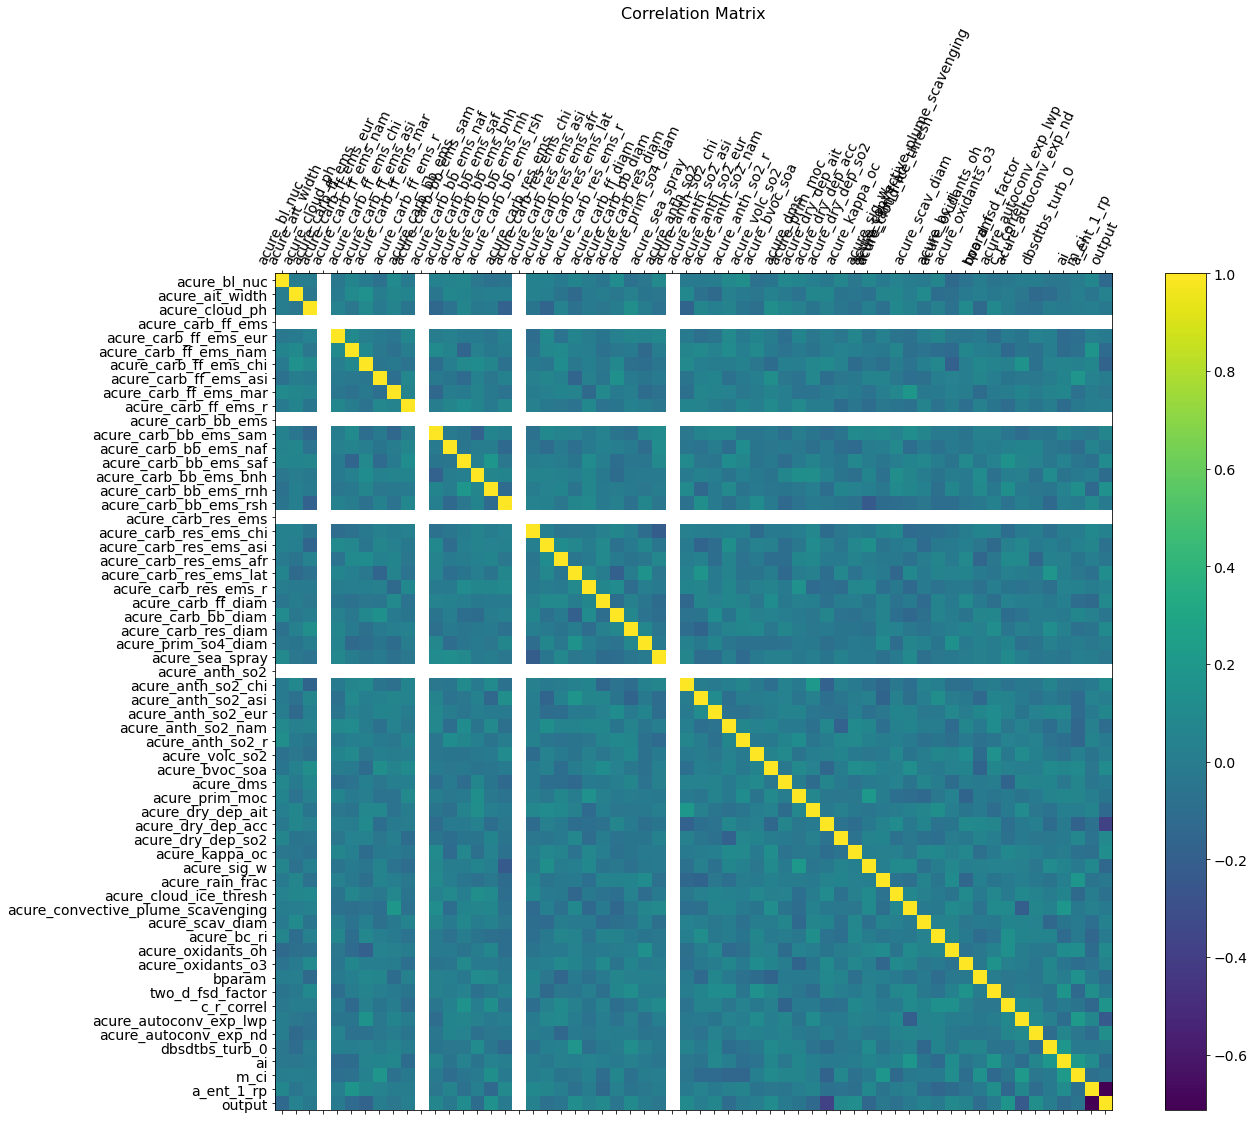

In [9]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [10]:
df.corr()['output'].sort_values(ascending=True)

a_ent_1_rp                          -0.713792
acure_dry_dep_acc                   -0.385413
acure_autoconv_exp_lwp              -0.231632
acure_carb_ff_ems_chi               -0.171067
acure_sig_w                         -0.135501
acure_dry_dep_ait                   -0.130136
acure_bl_nuc                        -0.124792
acure_carb_ff_ems_nam               -0.112625
ai                                  -0.107089
acure_carb_bb_ems_bnh               -0.106286
acure_anth_so2_nam                  -0.102596
bparam                              -0.098628
acure_carb_res_ems_asi              -0.073826
acure_cloud_ice_thresh              -0.073669
m_ci                                -0.055062
acure_prim_moc                      -0.045736
acure_carb_bb_diam                  -0.044264
acure_carb_res_ems_afr              -0.042117
acure_carb_ff_ems_mar               -0.037393
acure_sea_spray                     -0.031586
acure_rain_frac                     -0.027684
acure_cloud_ph                    

In [11]:
high_corr = df.corr()['output'].abs() > 0.1

high_corr_vars = []
for i in range(len(high_corr)):
    if(high_corr[i]):
        high_corr_vars.append(high_corr.index[i])
        
high_corr_vars.remove('output')

#### Conclusions

Conclusion from the last session is confirmed. Variables that have correlation to the output above 10% are:

- a_ent_1_rp                          -0.713792
- acure_dry_dep_acc                   -0.385413
- acure_autoconv_exp_lwp              -0.231632
- acure_carb_ff_ems_chi               -0.171067
- acure_sig_w                         -0.135501
- acure_dry_dep_ait                   -0.130136
- acure_bl_nuc                        -0.124792
- acure_carb_ff_ems_nam               -0.112625
- ai                                  -0.107089
- acure_carb_bb_ems_bnh               -0.106286
- acure_anth_so2_nam                  -0.102596
- acure_carb_res_diam                  0.109154
- acure_bvoc_soa                       0.110368
- acure_carb_bb_ems_saf                0.111606
- acure_carb_res_ems_lat               0.127404
- acure_kappa_oc                       0.129123
- acure_autoconv_exp_nd                0.130251
- acure_carb_bb_ems_rnh                0.151206
- c_r_correl                           0.174655

# Retrain Gaussian Regressor with selected variables

In [12]:
X = df[high_corr_vars]

datasets = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = c3.Dataset.fromPython(datasets[0])
X_test = c3.Dataset.fromPython(datasets[1])
y_train = c3.Dataset.fromPython(datasets[2])
y_test = c3.Dataset.fromPython(datasets[3])

In [13]:
gaussianRegression = c3.SklearnPipe(
                        name="gaussianRegression",
                        technique=c3.SklearnTechnique(
                            name="gaussian_process.GaussianProcessRegressor",
                            processingFunctionName="predict",
                            hyperParameters={
                                                'alpha': 1e-10,
                                                'copy_X_train': True,
                                                'kernel': None,
                                                'n_restarts_optimizer': 0,
                                                'normalize_y': True,
                                                'optimizer': 'fmin_l_bfgs_b',
                                                'random_state': None}
                            )
                    )

gaussianRegression.interpretTechnique = c3.Eli5InterpretTechnique()


grPipeline = c3.MLSerialPipeline(
                name="grPipeline",
                steps=[
                       c3.MLStep(name="gaussianRegression",
                                 pipe=gaussianRegression)
                        ],
                scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLRSquaredMetric()])
             )

In [14]:
trainedGr = grPipeline.train(input=X_train, targetOutput=y_train)

In [15]:
scoreGr = trainedGr.score(input=X_test, targetOutput=y_test)
scoreGr

c3.Mapp<string, double>({'MLRSquaredMetric': 0.7525918635022929})

#### Conclusion

The score in the test is of 0.75, compared to the previous 0.08 of the model that includes all variables

# Predictions

In [16]:
testPrediction = trainedGr.process(input=X_test)
concatResult = c3.Dataset.concatenate(tensors=[testPrediction, y_test], dimension=1)
pred_df = c3.Dataset.toPandas(dataset=concatResult)

<AxesSubplot:xlabel='ensemble member', ylabel='Black carbon mass (kg/kg air)'>

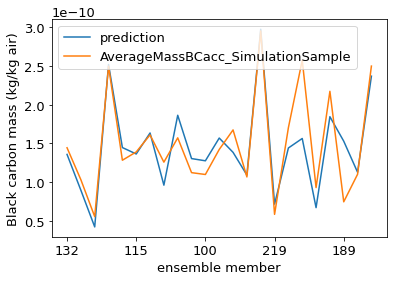

In [20]:
plt.rcParams.update({'font.size': 13})
pred_df.plot(xlabel='ensemble member', ylabel='Black carbon mass (kg/kg air)')

Looks better!

# Interpreter

In [21]:
interpret_result = trainedGr.interpret(input=X_test)

500 - ScriptError - c3.love.exceptions.C3RuntimeException_wrapIt [503.4814]
message: "Error: Pipeline grPipeline interpret() failing at step gaussianRegression, giving the error:
JavaException: c3.love.exceptions.C3RuntimeException: Error executing command: /usr/local/share/c3/condaEnvs/dev/tc02d/py-sklearn_interpret_3_1_0/bin/python /tmp/pythonActionSourceCache5951559007594397895/SklearnPipeV7d21_interpret.py
Process exited with 3 exit code.
a_id=4191.166188734 a_implementation=python t_tenant=dev t_tag=tc02d t_type=SklearnPipeV7d21 t_action=interpret p_logger=action url=http://dev-dti-app-m-02:8080 connector=null mode="thick" Action failed!
RuntimeError: Check if your model of type <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'> is support by the Eli5 library

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "MLLeafPipeV7d21.py", line 271, in common_interpret
    modelCategory=modelCategory(this))
  File 

C3RuntimeException: 500 - ScriptError - c3.love.exceptions.C3RuntimeException_wrapIt [503.4814]
message: "Error: Pipeline grPipeline interpret() failing at step gaussianRegression, giving the error:
JavaException: c3.love.exceptions.C3RuntimeException: Error executing command: /usr/local/share/c3/condaEnvs/dev/tc02d/py-sklearn_interpret_3_1_0/bin/python /tmp/pythonActionSourceCache5951559007594397895/SklearnPipeV7d21_interpret.py
Process exited with 3 exit code.
a_id=4191.166188734 a_implementation=python t_tenant=dev t_tag=tc02d t_type=SklearnPipeV7d21 t_action=interpret p_logger=action url=http://dev-dti-app-m-02:8080 connector=null mode="thick" Action failed!
RuntimeError: Check if your model of type <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'> is support by the Eli5 library

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "MLLeafPipeV7d21.py", line 271, in common_interpret
    modelCategory=modelCategory(this))
  File "Z10ac078826d8534179d455db1588a325M_.TypeSystemBase", line 1128, in interpretImpl
  File "Z10ac078826d8534179d455db1588a325M_.TypeSystemBase", line 1113, in _c3_static_inline_impl
  File "Z10ac078826d8534179d455db1588a325M_.TypeSystemBase", line 1101, in inline_traceback_impl
RuntimeError: Check if your model of type <class 'sklearn.gaussian_process._gpr.GaussianProcessRegressor'> is support by the Eli5 library

The traceback for the inline method is:
  File "Z10ac078826d8534179d455db1588a325M_.TypeSystemBase", line 1014, in inline_traceback_impl
  File "Eli5InterpretTechniqueV7d21.py", line 100, in interpretImpl
    contributions = _calc_contributions_batch_eli5(model, input_df, input_df.columns.tolist(), modelCategory, positiveClass)
  File "Eli5InterpretTechniqueV7d21.py", line 27, in _calc_contributions_batch_eli5
    raise RuntimeError("Check if your model of type {0} is support by the Eli5 library".format(str(type(model))))


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "PythonMLHelperV7d21.py", line 320, in dec
    return func(*args, **kwargs)
  File "SklearnPipeV7d21.py", line 402, in interpret
    return common_interpret(this, input, spec)
  File "MLLeafPipeV7d21.py", line 277, in common_interpret
    interpret_type_name))
TypeError: Eli5InterpretTechniqueV7d21 is not a valid Interpret Technique. Do not know how to interpret the data.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/pythonActionSourceCache5951559007594397895/SklearnPipeV7d21_interpret.py", line 406, in _c3_remote_bootstrap__run_c3_action
    _c3_result = _action()
  File "/tmp/pythonActionSourceCache5951559007594397895/SklearnPipeV7d21_interpret.py", line 535, in <lambda>
    action=lambda: interpret(this = _c3_inputs.get('this'),input = _c3_inputs.get('input'),spec = _c3_inputs.get('spec')),
  File "PythonMLHelperV7d21.py", line 328, in dec
    raise Exception(errMsg + " " + e.__class__.__name__ + " raised: " + str(e))
Exception: For given Input: shape: c3.Arry<int>([23, 19]) TypeError raised: Eli5InterpretTechniqueV7d21 is not a valid Interpret Technique. Do not know how to interpret the data. (MLSerialPipeline_interpret.js#15)"
JSON: {"this": {"type": "MLSerialPipeline", "name": "grPipeline", "noTrainScore": false, "scoringMetrics": {"MLRSquaredMetric": {"type": "MLRSquaredMetric"}}, "trainingScores": {"MLRSquaredMetric": 1.0}, "untrainableOverride": false, "trainedDate": "2022-03-09T22:57:19+00:00", "trainingStatus": "TRAINED", "steps": [{"type": "MLStep", "name": "gaussianRegression", "pipe": {"type": "SklearnPipe", "name": "gaussianRegression", "implType": "SklearnPipeV7d21", "noTrainScore": false, "typeVersion": "7.26.0", "untrainableOverride": false, "technique": {"type": "SklearnTechnique", "name": "gaussian_process.GaussianProcessRegressor", "hyperParameters": {"alpha": {"type": "double", "value": 1e-10}, "copy_X_train": {"type": "boolean", "value": true}, "kernel": null, "n_restarts_optimizer": {"type": "double", "value": 0.0}, "normalize_y": {"type": "boolean", "value": true}, "optimizer": {"type": "string", "value": "fmin_l_bfgs_b"}, "random_state": null}, "processingFunctionName": "predict", "keepInputColumnIndices": false}, "trainedModel": {"type": "MLTrainedModelArtifact", "model": "eJycvGdTlV3XLUgSJJpABYmiEgQERUVFL0VAMooIKAKSFCRukiJBcs4555xzDlVzVvVf6OrqD/0X+h90j7l9nz7VferUqernft/7hs3ea801wxhjrrWuXaGVnJ+RmZqYl+32I7EwPz89MTshNy8nOTU/3y3hR26ewbv/evX9vxcjUn/k4T85eQYqDadKlWaZSssxRldDQyMjNS87NVOlHRZzAb8lZuamJap03r3830v/j//tfz09jtHHizm5BelZ6X9S81QXYozx+/es9OyEzISk7z/yE5JUujGmeC07AcMXJOYV5Cf8t7frBWvEGMofc/KyEjPxUkKx6mJDjBFeSs7JLU6ISSjIS0zPVun/ey0vMTslJysBwxSkqgzCYvT+H/MSVIb/4+X+e0u+AVaaUphcYKAywgKNy1QmjjFaMoKH6tL//MNvc7Ixb3ZBsPp3A9VljHGlTHXVMcZEbe2/vyYUJWYWpqquvVP+Tw31/2LM/ru/JiTlFGan5KtM1Q79nv47NUVlVpj0z5aHquv/c1sifPwNVDdgwM0ylbmj2jWZqdk/CtIS8pMTM1NVFv9t+mv/n7/9Z/JbaZgSk+rg7wl52T9UlsnZhVm5xW7/fOyWkJueDDMMEhL+vaD2eUJygeSHldrxoZEez549eqqyrlXZRKhsy1R2jurgJ6UXJPxIzU7NS8SbVbfTrNXL/Bcz+zLVHccYbXXYilV3k1PSMzPdEuTfBvhMQUJiQQHGv/f/ej09KzcnryAhC7GDPSqHGEtJGLWtyTl5qW4JWYWZBemJeXmJxQmFWYkFaSrHWpVThMpZ7Rdkndr7eQi86n6dyiVC5fpvpQbZKeoPGajcgjVqVQ/S7qU5qBeWkJyTkpqcr3KvVXlEqB6qiyA1W15UPapTeUaoHsdoyjpVT9R/ykwsSM/2UD2tU3lFqJ7Vq55HqF44BmuG5mrVqrz/a6qUguJc2P5SHeNCT9WrYI1gzXqVEqF67RisrR7OW/UmLCws6P/C/9T/CtYoUPkkNaY9jhkzUYeSKqLyDT/w7C89OrUzVXiYl3nnJx1yK1e58ymN54ZeDKLhlHcuubyaYmZFDbRk+iKKzt7wvsJVVJ2i9e0zrfEMdXBzPh/SlgVvUA8fPEzkbRoK5pXrvEbVVEOTMV5Uw3P46xyt0byKhsu/F8dmB76mSqscR169RStl5XE8bUDzPHE3mxvogPeomleceNUm+zJ3P9GIzaNdNz7+9oFWL/KKVUjyFZ6k9Rxu/clbdJrJC9SfcT3Dwp3nH/BsFu2Xe3Ef9dHIhzBYd8g9nwK1aCQunrpuUD0vfqXWP0auCS489dAhnnofa2caX3t6n/fiuIKnafQNbXPDFXy8ks54/BJX8hRXeOVzDbXx9D1apR2q5QraojUvrb9vsaSuO5e4uySu2DLBjSf1LZJv3fbFSIdclwQrO6jTPwDO6+Ma/FZLhy68reJOM23e55kvcb607nCB5rJ5jJvteecq7K2A94f/0u57bjU2onXacXfi+j/c5YXlYfbBTzzEU7GX/9zmeh6hCg/a+puizUuXv/yh4RLadOWVB5pUYf8mPw3vPo9+HvUUgxxH8AlGHuEuRZfXecFBmyt8PP3ohAfuUwV3a71+wh0XdX29/Fw++iJwU7TL8+oJuvicR24/+/z7OXfyILXkl3GVTVoUL8JJCXqwe5LreO8FLfLSIzp4pEmnmK6Bu99e1c14hkCuaRgjXSq/0gEGneMd7ih0/WPE9Vep5+89vddcH/bYljfhm13YNU9brnRGNZYKD5kgd4Z425u34LqDaxc8L3ykfqr7Rmsmjy4VhNGxEVKqk+tpkyZp2wYeXnDkIxqnRhq7x4M8nGJliwm7kqmVD9+mUS8NcA8GHyXxxJ5CRzxKYzQXRQdvH+OHHT2uclM+xIZigH7vqKvevM11D3nO2Z/2VZbZ8SqTG7m0AmdVaFJHXAhP0NY7nix8zruGJcZmr7hH8ys1a9Kk9lU7auFq2rOiFhVP5XIjTdBJHB9fo2VNOg63oMk3N3SiigpolRf/vInjal6leV0a5HFtF63rSTE8jsRrvEnHtAET1ukUcai5QbVPeDiW6ngTHq7gcbw4zJN+3FVA3bx74wbctISAj2C1bXwQF8fbnyx5mkfTaI927yfx+F8rN177cNmdmsIMafapPzXRwHV4Y+Ymj4Rx131ucTSmJdrkWWQQH3xBPrXDqZ08+cUi1ps2aDyUD1ADC5ZBPOtAzQjGSiJMP3kAG7doIIYXv9ASN/NaYQkPlvMAbxcBT5pp3o6mufsKothiAK/VOHMtllHtQWMlVPv1hxVSqZ73f6DA9vxQdNs0H4YFDt/Tf/MnOJL3uJdWTLW4kxZCsOpq/FBJrVT7l481uZFrAx7ZsgR1QJ8PX+hz54ME1P4sr6Xw9CvaSEYKnd/l0XiqefaFZrLTc7CGsYJkWqaVNDp7HPcQ1T5D8wY897Aokpff8rRXIvXq56NoDE0NkCq9Tmncb+6cgag0WnO9H21o8WYWDVIj19j/dbXiRtVfOGDxowd3aTtwBw9RP8/CdfvG4TzBky+Ci6mJN/485fmLmdwFyDyxtOKpK0jbVndf7jTJBDqcelyCj2YLeZlWo5Au/Y687YS3TqMqtm9kc5cFtbz21n3pk00z1B0LW45Cs5ydfVE4VdwNmG3QdaFhAO8An9OQkokk6KJeYFAVH/CmMRy+gWxZibW+k2lIU9zD/YhnHw+peNiFOpH8LaW8lP0tl6atDJFCfXT+zUePT2jWTXXFWLGyQRaM0Sz1lRjSDAaroHo7z/dB1JiBpS1lc/W3ct1rb+1ePX9GO9wL0Biywicqomi0tNA/2jrkI1Ck2e6eLQ0+4D7u0qcdU5DBmAGQdYaaNbj5DSI6qK9T9IVbeOA7tQQiofrecb0/0HeBBz850D7GrbVBpLEUw4/RV2nqr95tVNApUnbcMBDr6+fGbB7ldWNaKPrkwXVXqKf8ExDvOM//NtXT7ktjmsjjFmo2+YZBBkrgg33qfHIPaL7phR8PtQzvatGkEXy2wXMeGHHWH6DV8t0HmXnAY8ZY9gIPGyHAczkAmq4LvOGShJdmH1Izj/gUa8dk0jnKcyKNx36CwKaT4vgw0vsTjVqbILodH4tp8jG8eJDhzK10Ti16tG/KS/EomtoAf57DKAdZSMf1h3dysa5WGkp3pmOeTqWOYADBAq862XBD0qeycAdjPrSg2hRzXqSxNKyx+W6Rtj91F9AhLVndAUG0qoxsuS6fhj9Tfwrtfo4F/NVmp/J0yis+0tSz5vVIPs0A0m3+CH1D6xq87B1PkzwZ8pTbkES7kAHNcNrMdZpNKkASNhr6Xn6iF/X3Jp2Z8t4nP9o04hW8tcWM1z6WC3PTsaUdyrA/F2jceg/I04oM7+TVqLeKC8KyGsAz6cXcl8XHtP4RVDD69RL3akUm0MQnq2sIyMlTrHAZg84+B4YfxrsiC8+42VIfhizTyF9HO9RFXwlQZ/qLYAS15OLNUzxqTae5dEKjkBgj3HjjKzVpUxXmrsiIeQGntt6jIweu5c7yTAzQ+SyZBmilJOmVUXyoI21hgHWwwTbVXbkXlRPwnVcMs5IgY07SY5E/QPEphPuEd/Iw70SU7d+PPGXEa39o5c3Ni9+jqT3ChKeeRFBzAWiwi7tTubnAj9sSftIY71p7vy0HE8yijscTMGsl132l8TjTaNFSGG/fnFDxtVR938jSJ+5yNOZpemsI1mt0zC5978Fjb4B3w0iUPa2LRbSsw+0ovjpesuBTfTq5mECTWsm0FoSUXuTV9/m/sOYNd1Dc4vtI7v9Au9opj37TqO9b0GQVXNjMQ9fvgtRr7tJiZgx1IcF2uPFx3k2w7ixPxpnxeoEDjToBHWrNdfgYqmqNdsHUXJ361xaIDm+dfQK+TDsAd4d4L/42qvXEQDflKp3l8nkctdHhtXv+rr55fPDLPwyZ3kIziU/AP828cRO1usTVxqFcHcf1vlSH0moI5d4cQFV9jgWEwhAvxN+Ft2eQOb1cn+bFe453QDOtpTQdV5BOu9T/E+yyH8lN/tTwqoyPtHlAuU5nr/mIu97Ryg+e/eQUCeoYcvWGz0/zbd+XXU21fGfoWQJqPNLkSg2gXiUflaK6Wm4A9dqCjcGENH8TeVIBLw56Ionmv6SCUSfx6zgfqngsl+a8sZZKqv52/Sq8Mf4MqJHj5gbcHLwJUhuiSmcANWAoQROGCyVx/U0IzVkU0gpQ5iwd1VEdhlSAR6Hl7EFhZwhkDa/pcs3ldF6DruqhEbPHNHHfqpCXDGNSuQEwVFfOC3pOIJejV4jRyEOkI+jlK7VpIWX7gwCla9wZ5JLlBsY74VoTav9GFX73dKz4MDCFz+J5/Ks2/tSfdv8bLybCS63fc20/hND0DTuohXUPWjDmxXffv7/wTXamSsf8+Cw6fFMGbVuBJKwqplMXAz57zgdPue/tnV9Yz3Yy6uHMLIA2DIxThJTGoaup2vGeGw1fTv0erSCYrdpZSLeRt0+5y4/a9eg4Dly5+DAIrqjL+ZPNuyCHHxaXeU5LA8ze8UL+PMQDRmDO/VCa+J0GaF3jDmdeK0YARnjseQYm7YNFqIcVno8h6Sx++t8H601TO5+F0jCQ6xAemI4ue26Lt07yXJoZ9QYBi9dpOgVocWD1RSeBa71uu9F5MW9dd7/iZY0IrBogzs3ffwPra2nNEjFco8VLLzRdeCLDLtSbFxKD7mGSmsevadk6CRnbTIea15H7y3yaWQ4yGkvkhUvcRGsAVBq/Axw51LlubBoZ85nnvmvc1IS0qXQudeGdJN2gaBHvYOF1Fa0VU4Mv936HmqrP5AFv3r0Nld1h+wGabzMyJOPFY168TJ2BqP02JxIK7NbyonFuh5YcpObkl5ZvjajliTH1vERmVtCwGZ05xDwAqk7qm0aBKefRpAxh8oH3n/KopQgiecERhYEshizrIui7ZT3uMQvHa53ZtJmm7wTj1r8+5OZLGcCFCbCAvi1NZ9OUsyWgYzIUYnGGD6J5B/rjSN0I7ALR5kJeX6Elv2IHOi61BDJq4q8VDwHmNb95OIjrbpY7v0Lvtx2LjmIIYULP4Jmg/wxVfGrwhXcyLwdT53eeT/pSaojRDqkhhbd/FqvepqH99Y1Q+RWo/JPU/X1uTr7qXWiOVqF6gygtMT9BvZuhCgjWUO8H/Pst8J3Gf/2vMEm9j5Kd8D01saAwLzU/IT07QRUUfE29p5BQ/G8jKCErNTFbFZzmmqbu2UPS0G+HRqjC0G8Ha9aqwtP+ddjfvVTv/3XYHyJUEeiw0/773vqjureWzScbUF+nQexlXnipipSFfIpQRRWoopP+bSD8Z+r8ghRVzH9m/iwzf4lQxf7XzF/TIv4z3HvqDnnNWzd54KUqToaLj1AlFKi+JcVclA2Z/xpNlfifoZJkqOQIVYoM9b8EX6tTpf4b7M4Gmv5+UBzy6IwnFPtYcw8jRx5SUG8Dj7n9OiRXi2KTTSe/qTebm5TX9rxlpG3NlUocTfiGAW1GeVjhyiIQ3QbotoJbFER11xSgtIdS7VUu0YYGr/LkL15XgP3DgL0TJOIB9yhoYhq+oAXt/oAZ4zDVYAIo/IgbFdosRUZ2FwF5uxSA3mYWOG/OjmsVnXAefYbxBulUeWtDC840nsHdSiIm3b+Dt49StwKYBe3fom1fXlCevOQKX+5A07Gu/HIGLx5puOKz/h4YdpCq/HheeQbg9wNstvKKwj3hQPXOzEIs60/pV27iKfQlPUpJkFkCYHyKzpTA3zbA5BCeVNI+voa6GYHcm1J45zXveKfflWW2QZntU236YyxF4TYPcCtqfEShBrti2kkAvvQpAKdzuOscfLAGz1NFns6rYjDJrHIvgDaDc2V7BCLpiNcfQe+OwzQA6owln9hwhWKE6r5K689oUMmjKgeTcKDBokId6DL2Qsq+4c0ZfwAM7QVQ+92Kgy5KcCYa71lQ7B7zhoWTI95hX/CNO+NVcPBX2sPSVnWteFWxcCjWBUTO04QCEbQEudNA+3q8BBSndT4L48kACXhtop8FdzyC8xD0bT69FZbKa0qyDjf6YWGz3KkgBJW66LiBztyv/A6BdliGoK7hDuUvuK7/lcoJC8TMR9xtws338YszVflSFVB3Gb5N51ojzD75BH+I54q8SO4Ohf20CO8OA+bH6Ig2lDJefMArN2B+hxIEflzkudeA+iWFa14iobpp2hCLCoPxeyUgk+USBa5sv6AV8ximv+M1e+q7CcXTrriBS2bSAiB+l5HAsbCzjypL4KY4vRLuvPeNGxRawRrG8M+iOvvu8loOgLP9AqzyTuZzOEXIV7Ex4smXtBICI26jDdvLfgVS6VZ4+9J1muPu1zyjgMHaaMnkOUhjVLECt/ZDNO0WI0N4H7ndnE47kRjpimzlYKmVVqi80HxeTnMLxZr9APgzdOiAnrxDeUzjFiK/yrFMPr8O2ln1BuGuK48w1AF3P4QGXVNsowDlJyHaPKYUyx4FlNUeJl9VqNobonMvH9S/pkj3acNHEOLweeEjwHtVJnoNOL0/PATUMQ0SmVQiqM/LmZdvI2mhwnu5NR4EuYKFRKDvq6XmBEi6dUXjwZM79p7IZtpPSU+jqhx8ktsfYVJE4Y7kUwPs76QD9wvUqRShNR4BQW2YSikMUK0zV2QhedYUPlW7u8ETSdWDWqJNnsnnlULqUcKfgMJ2kCNtPI1pAnhNdRdkijrYTQWn7erCL6eKBepgzR3gtC1JOU21P3XR9nRys0Izl2gzPAvEtaS88KTdp3ScQDNKEhTVxHMEZRXoRTMf0aW1XH4hKbVuj2ahCYoSc6APHkO+HVP9ZRQ/IYU3Pr4CukwreX6/f0jfPaIEIz2GwL8jWQIsm87cXR7N3fAtN5jFpqDL6MNA14CUjXTmlQkPYj3DUKMN0Z/klyG0mD2GSri4ZJF6IINjeIIHkT33FbD2FEoAuXqoe0XHHt1in2IepG4X25/D/Zd/ZT7jnkI4XdeE674YFfG4QpOZmSDsERZP0hzycuJdEYx3uEFn5tQRI56roJEPOVavZLXNWOB5qSuQekn8dq6bSn06EpGBsi+RtHRBMG8tVQ1jtY543cfjHpTKJGAVadWBqp/5bAA8a1SuZj1z9ocSG1Uswug86SoyoEr812hE03pwVIeS6/CQ1wMcCPlfqSpNRLAa4KUnl4E9a3/hh1nFRvmGrG6HSUjT/mIsvebNY7wOvXxih9TY5U3Jtf70O9DW9cgJGNfmRbNZl8Fr00qSytTVE+GC9YvRj1KhKqrgkNdv4YxdrTBkCSLXBcKqehMLdLXmrnvU+B4dLiaY4K0CakhETawoNBxHVYFIjB3kUvIDPr1GC3/Qb4DDEMo0WFeJYMVepcO3T9WEw9UvPqDWTtRQt41EXQvxw39hxorqcUYUahNhqVGF2Nth/C7lAS1HJ9JABrcp6kLZMP4EyECtdBdwf9QlyMF65bIj793nA9DGklJOg6qbaK3HMeJ7FNM6bcVAkM4qWhqBwK89rBg1c/I73VtVJLBzgopYz0mJxLq8n9PGO3y0HcsKpqGPKPaREAxz1UrFM7GojwkFKrFLn8ZfIkB0WFp6zw7QuapEcouz59fPNKA4+NDyVdoup00l2anoC/f+wJ/TU8uv8sFHrN3PR8Ps0Q/ahcuvoy3qVm98iQ2LvHFHEhZrTwkErKzFPwFDpCSX0qgQ/rRyHQC/GJvxQBK/i6YtaNbzEQYs4LY7oKZz2ZxTykKo1gF9PszPkb3Ne8CPRpmsmVdBM3Pg2yNknDWfXKaOZ/ZYcZSbzy0+Shac3LChfbir+w3S5DdiNh9pCx4HgnfpGAJ1BkOBkzQbZhFCZ79gM3WbyTa/RxBNKYGxb/2pW97gz206dBwAPoBcOrv1k5t0wDhnwLJ9an/8sRRJfi0GC98FOB5K8qzwtt1FanXiVgW8UO9GCznmglyyL1HH6GMPkQJ/aUaV+xgKZkXR1vOxsYK2gMENz7j6J2194WqlEBTV9OITb6crKM2+bzxuj2QGIJ1dhikNVK0nH2iOSr91AwQOrDlSsr9GQI5sKVQLF9XTVigU/qQSFBWQG/NLDJgxNM6Atyp5GR4IpIEUn1eAE1BShwMi0fAIWJlZUvAeeT8phD/g9+ExOHMD81y05t5MrqI+jGdPG0lUp4H44D3jfPoMsVzOEDk0ZPaa5+9ASqFSung4NpsaM+X1PRLROMiHeKuSjQysdQLHTKG2Sg31LCEXTpHjaCOQM8dBObStJF5CF3gOQ+sFqzovXORqhOtUjD3hxhRw3DJMWVZ04EpQpw6waE2JADhs8xZtWMB7SI7VW8iRBk/MQp0OKKT20FcEj7UXA716pVfFAPeoWSNQNxdky+fa3JoM2FzELDT3jarfFIGuu5SnoLnTj6nukML+n2H7PHw/INA3ln3ZjA8TYa49iLaZeh78RgVdRjmvUxvwvQIfDoXUCeMdL4nP9hMPpMAAFAdwttrxTr6JORyuxY2fePiJp6TfHLUYBsbDBmBfW7AZnb9AZAEuXU7UAAIcv00nCqbavwrJhLKfU0yQdksxiEuzGFQpgjwnEBppRXnOa4lWHgUQPDyVS3vWcehkN6DhnKjujQ1MBE8tyPaWMdfdwoJzucskkfdfwKA7OrQd6ybHRMjRSjBND58IXdKw+218cN4eRQnEXEES1uSYyMIWAx4hQ4cvYPUvnQCHk6VGqPPLcPmwHiplEaLIySPqBbRZs9TbwAN9kMkwinkBXjenrUJNqgYEPPzM/VwHwNiUxF6Cp3pvlWI4IPyAE+H/epIQsVdQiimhgPBRUXgdkaiJfsD0gmIf8pgH40AR7WgxNuGYHdo2B+JTe1jM6/zvH0FiRdyDBuEIqxJBRIN5SWnIGWAh0qmax11pAizGS++pNaUsVBqSbj...